# CAS Intensity Limitations in Hadron Beams

H. Damerau, J. Flowerdew, A. Lasheen, L. Intelisano, M. Neroni, C. Völlinger

Acknowledgements: R. Heine,  S. Lauber


## Links
- CAS event website: https://indico.cern.ch/event/1466612/
- Programme of the CAS: https://indico.cern.ch/event/1466612/timetable/
- Python software installation for the exercises: https://indico.cern.ch/event/1466612/contributions/6448899/

# Introduction
In this hands-on session, you will explore the case study of beam-induced heating in the CERN SPS wire scanners. You can choose between two approaches:

- Use the provided `support_functions`, which are designed to reduce coding overhead. You can check the documentation of each function by calling `function?` in a new cell.
- For the bravier, work through all the exercises by manually computing each equation yourself.

The notebook is constructed with the following purpose in mind:
   1. Compute the wakefield and beam-induced voltage in the simple case of a single bunch passing through a resonant structure.
   2. Extend the computation to the case of multi-bunches for a LIU-type beam in the SPS and calculate the resulting beam-induced power.
   3. Analyze the case in the frequency domain and compare results across different resonant frequencies.
   4. Evaluate the impact of the beam on wire scanners for different beam and impedance parameters


<h2>Functions that can be imported from 'support_functions.py'</h2>
<table>
    <thead>
        <tr>
            <th>Function</th>
            <th>Syntax</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Generate a parabolic bunch</td>
            <td><TT>parabolic_bunch(time_array, bunch_position, bunch_length, bunch_charge)</TT></td>
        </tr>
        <tr>
            <td>Full beam from line density</td>
            <td><TT>generate_full_beam_profile(
    time_array,
    rf_bucket_length,
    bunch_charge,
    bunch_length,
    number_of_bunches_per_batch,
    bunch_spacing,
    number_of_batches=1,
    batch_spacing=0)</TT></td>
        </tr>
        <tr>
            <td>Compute beam spectrum</td>
            <td><TT>compute_beam_spectrum(time_array, beam_current)</TT></td>
        </tr>
        <tr>
            <td>Compute wakefield in a resonator</td>
            <td><TT>resonator_wakefield(time_array, resonant_frequency, r_shunt, quality_factor)</TT></td>
        </tr>
        <tr>
            <td>Impedance of a resonator</td>
            <td><TT>resonator_impedance(frequency_array, resonant_frequency, r_shunt, quality_factor)</TT></td>
        </tr>
        <tr>
            <td>Induce voltage in time domain</td>
            <td><TT> compute_induced_voltage_time_domain(
    time_array,
    beam_current,
    wakefield)</TT></td>
        </tr>
        <tr>
            <td>Induce voltage in frequency domain</td>
            <td><TT> def compute_induced_voltage_frequency_domain(
    frequency_array,
    beam_spectrum,
    impedance)</TT></td>
        </tr>
         <tr>
            <td>Induced power in time domain</td>
            <td><TT>compute_beam_induced_power_time_domain(
    time_array, beam_current, induced_voltage, time_averaging=None
)</TT></td>
        </tr>
         <tr>
            <td>Induced power in the frequency domain</td>
            <td><TT>compute_beam_induced_power_frequency_domain(beam_current_spectrum, impedance)</TT></td>
        </tr>
                 <tr>
            <td>Loads impedance data from a file</td>
            <td><TT>load_impedance(filename, frequency_array)</TT></td>
        </tr>
    </tbody>
</table>

In [1]:
# General imports
import matplotlib.pyplot as plt
import numpy as np

# Local imports
from support_functions import (
    analytical_parabolic_bunch_spectrum,
    compute_beam_induced_power_frequency_domain,
    compute_beam_induced_power_time_domain,
    compute_beam_spectrum,
    compute_induced_voltage_frequency_domain,
    compute_induced_voltage_time_domain,
    generate_full_beam_profile,
    load_impedance,
    parabolic_bunch,
    resonator_impedance,
    resonator_wakefield,
)

# Zooming with matplotlib
%matplotlib widget

numpy is installed, version: 2.0.2
scipy is installed, version: 1.13.1
matplotlib is installed, version: 3.9.4
-> Setup is OK!! Have fun!!


In [2]:
# You can get the documentation using

parabolic_bunch?


Signature: parabolic_bunch(time_array, bunch_position, bunch_length, bunch_charge)
Docstring:
Generates a parabolic bunch profile given the time array,
bunch position, bunch length, and bunch charge.

Parameters
----------
time_array : array
    Time array [s]
bunch_position : float
    Position of the bunch [s]
bunch_length : float
    Length of the bunch [s]
bunch_charge : float
    Charge of the bunch [number of elementary charges e]

Returns
-------
profile : array
    Parabolic bunch profile (current) [Ampères]
File:      ~/cernbox/Redaction/Events/2025/CAS Intensity Limitations/Hands-on/support_functions.py
Type:      function

<table>
  <tr>
    <td style="vertical-align: top; padding-right: 50px;">
      <div style="border: 3px solid #ccc; padding: 10px; border-radius: 8px;">
        <div style="font-size: 1.25em; font-weight: bold; margin-bottom: 10px;">
        <b>Beam Parameters in the SPS for LIU-Type Beam</b>
        <table>
          <tr><th>Parameter</th><th></th></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Energy, $E$</td><td>$450\,\mathrm{GeV}$</td></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Proton per bunch</td><td>$2.3\times 10^{11}$</td></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Harmonic number, $h$</td><td>$4620$</td></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Bunch length, $\tau_L$</td><td>$1.65\, \mathrm{ns}$</td></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Bucket length</td><td>$5\, \mathrm{ns}$</td></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Bunch spacing</td><td>$5\, \mathrm{buckets}$</td></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Number of bunches per batch</td><td>$72$</td></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Number of batches</td><td>$4$</td></tr>
        </table>
      </div>
    </td>
    <td style="vertical-align: top;">
      <div style="border: 3px solid #ccc; padding: 10px; border-radius: 8px;">
        <div style="font-size: 1.25em; font-weight: bold; margin-bottom: 10px;">
        <b>Resonant structure</b>
        <table>
          <tr><th>Parameter</th><th></th></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Resonat frequency, $f_r$</td><td>$800\,\mathrm{MHz}$</td></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Shunt impedance, $R_{\text{sh}}$</td><td>$11.6\,\mathrm{k \Omega}$</td></tr>
          <tr style="border-bottom: 1px solid #ddd;"><td>Quality factor, $Q$ </td><td>$985$</td></tr>
        </table>
      </div>
    </td>
  </tr>
</table>


# Part 1 -  Beam Induced Voltage and Beam Induced Power in the time domain

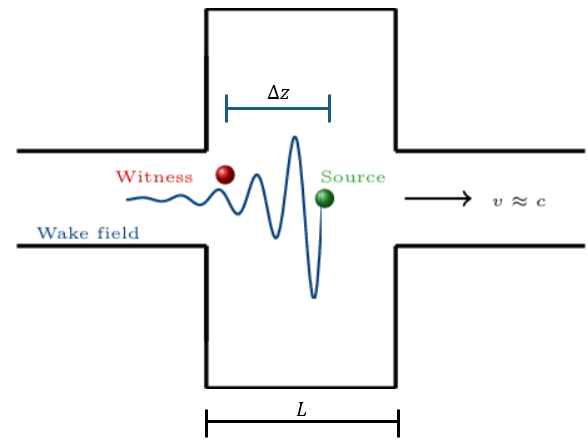

In general, in the longitudinal plane
   - A particle (<span style="color:green">source</span>) traveling through a discontinuous structure generates electromagnetic fields $\mathcal{E}_z$, known as <span style="color:blue">wakefields</span>, behind it
   - A second particle (<span style="color:red">witness</span>) at a distance $\Delta z$ from the source, experiences a force due to this wakefield.

The longitudinal wake potential is defined as
\begin{equation}
    \mathcal{W}(z) = \frac{1}{q} \int_{L} \mathcal{E}_z(z +\Delta z, t) d z\, \qquad [V/C] .
\end{equation}


Therefore, considering a bunch with a line density $\lambda(\tau)$, we can compute the beam induced voltage as
\begin{equation}
V(\tau)=-\int_{-\infty}^{\infty} \mathcal{W}\left(\tau-\tau^{\prime}\right) \lambda\left(\tau^{\prime}\right) d \tau^{\prime} .
\end{equation}


## Exercise 1.1: Compute the beam induced voltage for single bunch

1. Generate the profile of a single bunch, with a parabolic line density
    - The parabolic bunch profile is given by
    \begin{equation}
\lambda(\tau)= q N_p \frac{2 \Gamma(5 / 2)}{\tau_L \sqrt{\pi} \Gamma(2)}\left[1-4\left(\frac{\tau}{\tau_L}\right)^2\right]
\end{equation}
where $\Gamma$ is the [Gamma function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gamma.html).
2. Compute the wakefield in the given resonant structure ([see table](#Part-1---Computation-of-the-beam-induced-voltage)).
    - For a resonant structure consider the following expression

\begin{align}
 & \mathcal{W}(z)=\frac{R_{\text{sh}} \omega_{\mathrm{r}}}{Q} \mathrm{e}^{-\alpha z / c}\left[\cos (\bar{\omega} z / c)-\frac{\alpha}{\bar{\omega}} \sin (\bar{\omega} z / c)\right] \\
 & \mathcal{W}(z=0)=\frac{1}{2}\frac{R_{\text{sh}} \omega_{\mathrm{r}}}{Q} \\
 & \mathcal{W}(z<=0)=0
\end{align}

where $\alpha=  \omega_r/(2Q)$ and $\bar{\omega}^2=\omega_r^2-\alpha^2 $

3. Calculate the voltage induced by the beam.
    - Hint: use the numpy function [convolve](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) (or use the support functions)


In [ ]:
### PARAMETERS

# Beam parameters in the SPS
rf_bucket_length = 5e-9  # s (real value 4.99011801e-09)
rf_harmonic = 4620
bunch_spacing = rf_bucket_length * 5  # s
bunch_length = 1.6e-9  # s
# bunch_length *= np.sqrt(3 + 2) / 2.0
bunch_charge = 2.6e11  # protons per bunch
number_of_bunches_per_batch = 72

# Example impedance parameter
resonant_frequency = 800e6  # Hz
shunt_impedance = 1.16e4  # Ohm
quality_factor = 985


## Exercise 1.2: Compute the beam induced voltage for SPS LIU beam in the time domain
- Extend the computation to a full SPS beam with multiple bunches using the [SPS beam parameter table](#Part-1---Computation-of-the-beam-induced-voltage).
    - Consider a time axis of one revolution period.

## Exercise 1.3: Beam induced heating

Beam-induced heating refers to the power deposited in accelerator components due to electromagnetic wakefields generated by the passage of the beam. 

The average power over a time period is
\begin{equation}
 P=\frac{1}{T} \int_0^T V_{\mathrm{ind}}(t) \cdot I_b(t) d t \qquad  [W]
\end{equation}

Hint: use the scipy function [cumulative_trapezoid](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.cumulative_trapezoid.html).


# Part 2 - Complementary Approach in the Frequency Domain

Often, it is more convenient to work in the frequency domain. Applying the Fourier transform on the wake function $\mathcal{W}(\phi)$ over one period of the RF frequency $\phi/\omega_{RF}$, yields

\begin{equation}
Z(\omega)=\int_{-\infty}^{\infty} \mathcal{W}(\phi) e^{-i \omega \phi / \omega_{\mathrm{rf}}} \frac{d \phi}{\omega_{\mathrm{rf}}} \qquad [\Omega].
\end{equation}

This quantity is known as the beam coupling impedance.

According to the convolution theorem, the expression of the induce voltage $V(t)$ can be simplified in the frequency domain as
\begin{equation}
V(\omega)=\Lambda(\omega)\cdot Z(\omega) ,
\end{equation}

where $\Lambda(\omega)=\mathcal{F}\{\lambda(\tau)\}$, is the beam spectrum.

## Exercise 2.1: Compute the Beam induced voltage in the frequency domain for the SPS LIU-type beam
 - Calculate the impedance using the resonator model, based on the parameters provided in the [table](#part-1---beam-induced-voltage-and-beam-induced-heating-in-the-time-domain).
 
\begin{equation}
Z(\omega)=\frac{R_{\text{sh}}}{1+j Q\left(\frac{f}{f_r}-\frac{f_r}{f}\right)}
\end{equation}

 - Calcualate the induced voltage from the beam spectrum and the impedance.
     
     - Hint: use the NumPy [Fast Fourier Transform](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html) function `numpy.fft.rfft` to compute the beam spectrum.

## Exercise 2.2: Plot the Impedance Together with the Beam Spectrum
1. Can you explain the shape of the beam spectrum?
2. The shape of the envelope
3. What defines the spacing between the spectral peaks?
4. What happens if the resonator quality factor is high/low?

## Exercise 2.3: Beam induced Power

- Compute the beam induce power using the beam spectrum and the impedance
\begin{equation}
P=\sum_f|\Lambda(f)|^2 \cdot \operatorname{Re}[Z(f)]  \qquad [W]
\end{equation}
- Shift the main resonance closer to a beam spectral line. What happens?

# Part 3 - Evaluating the impact of the beam on the wire scanners for variable beam and impedance parameters
We now examine the relevant case of beam-induced heating on the wire scanner, an issue that has been actively investigated at CERN ([see reference](https://cds.cern.ch/record/2912932/files/document.pdf)).

You can find the impedance model to load at the following [Link](https://indico.cern.ch/event/1466612/contributions/6449148/).

## Exercise 3.1: Compute the power loss

- Load the impedance table for the wire scanner and plot it together with the beam spectrum.
    - Use `load_impedance(filename, frequency_array)` from the `support_functions`.
- Compute the beam induced power in a similar manner to the previous exercise

## Exercise 3.2: Compute the evolution of the power loss from injection to extraction in the SPS

1. Typically, the mean bunch length of LIU-type beams ranges from 3.5 ns at injection to 1.6 ns at top energy. Compute how the beam induced power evolves as a function of bunch length.
2. Compare the different scenarios with and without impedance reduction.
3. Discuss the potential objectives to impedance and beam spectrum that can further reduce beam-induced heating.
4. Provide an estimate of the power level that could pose a risk of damage to the wire.